Total orders detected: 42
Orders successfully fitted: 9
Analysis complete!


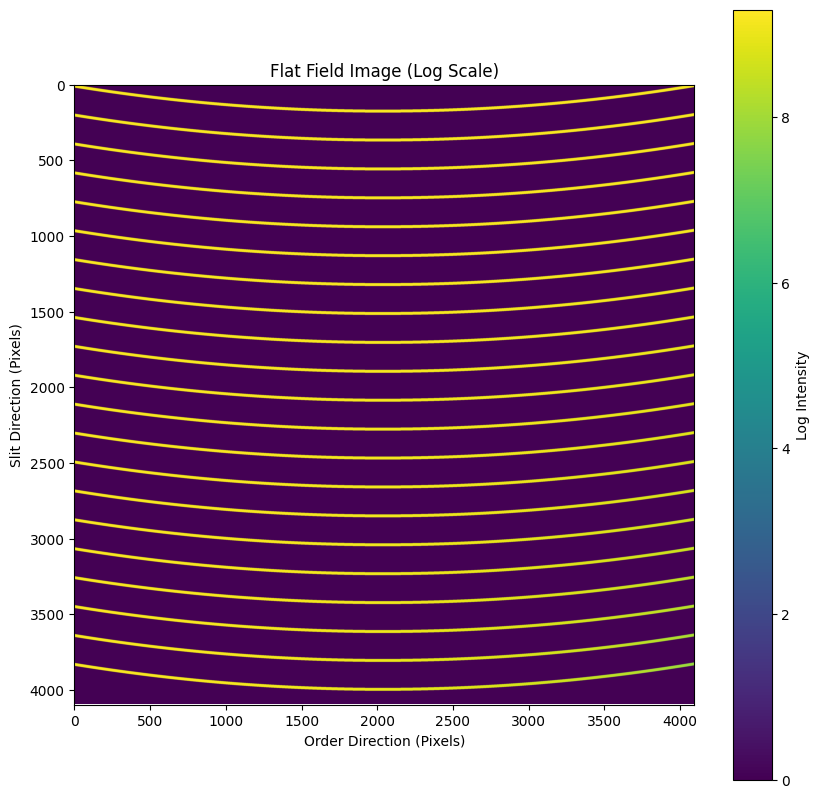

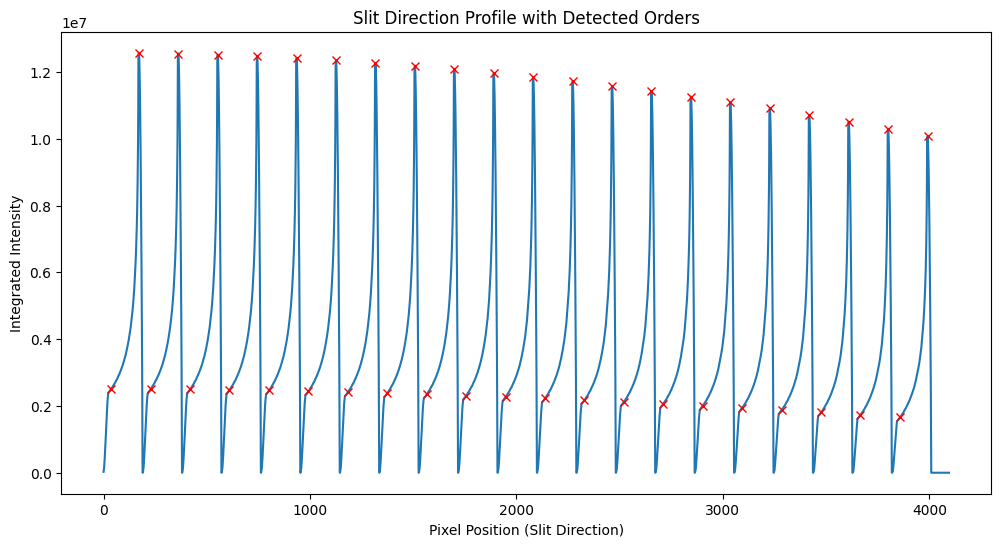

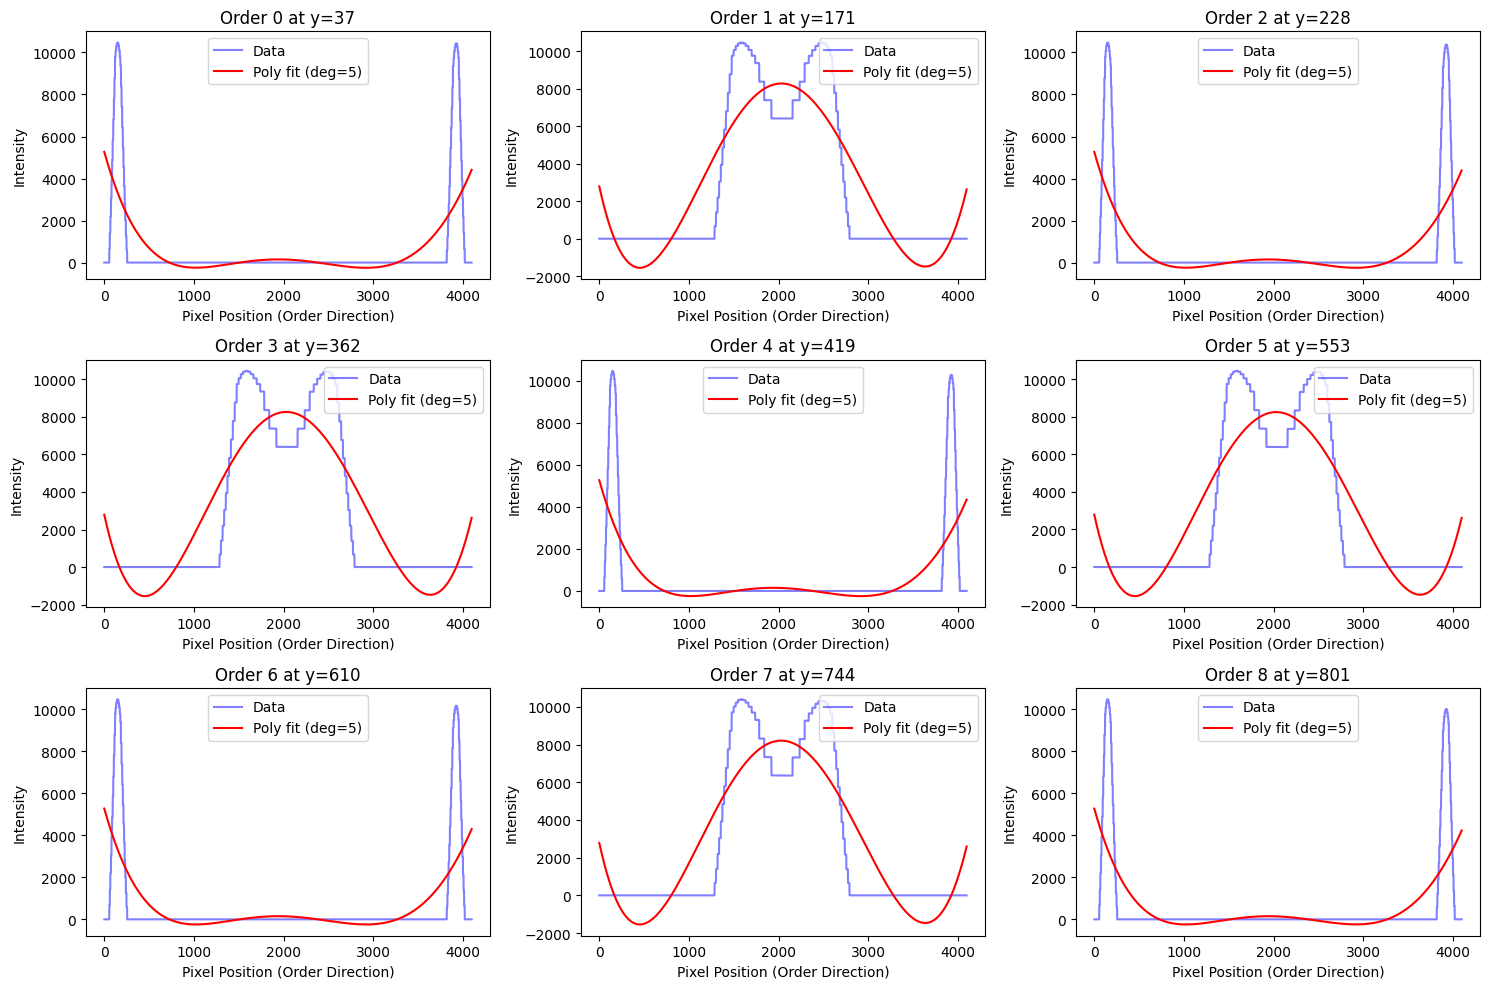

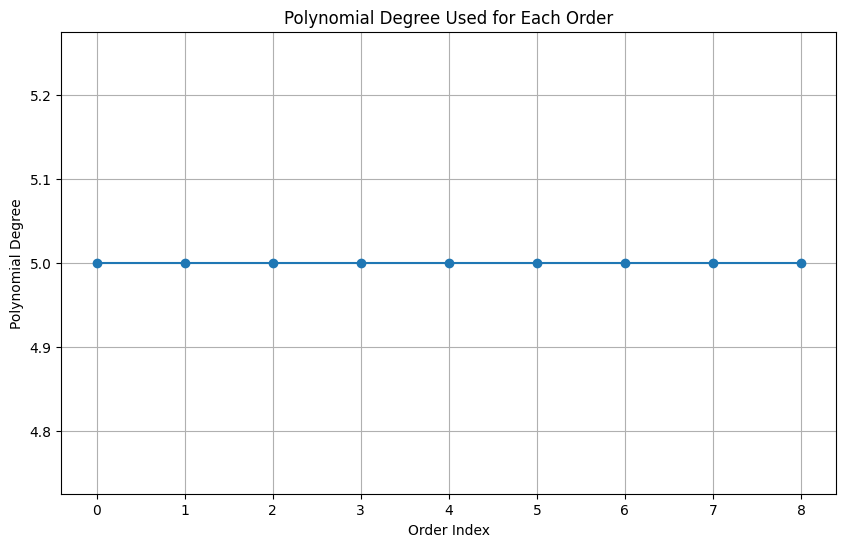

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import os

# Load the flat field data
data = loadmat('data/Flat_FrameShehata_Abdelrahmen.mat')
flat_field = data['flatfield']  # 4096x4096 double array

# Display the flat field image to visualize the orders
plt.figure(figsize=(10, 10))
plt.imshow(np.log(flat_field + 1), cmap='viridis')  # log scale for better visualization
plt.colorbar(label='Log Intensity')
plt.title('Flat Field Image (Log Scale)')
plt.xlabel('Order Direction (Pixels)')
plt.ylabel('Slit Direction (Pixels)')
plt.savefig('flat_field_image.png', dpi=300)

# Function to detect the order positions in the slit direction
def detect_orders(flat_field):
    # Sum along the order direction to get a profile in the slit direction
    slit_profile = np.sum(flat_field, axis=1)
    
    # Find peaks in the profile - these are the centers of the orders
    peaks, properties = find_peaks(slit_profile, height=np.max(slit_profile)*0.1, 
                                  distance=50)  # Adjust parameters as needed
    
    return peaks, slit_profile

# Detect orders
order_centers, slit_profile = detect_orders(flat_field)

# Plot the slit profile and detected orders
plt.figure(figsize=(12, 6))
plt.plot(slit_profile)
plt.plot(order_centers, slit_profile[order_centers], 'x', color='red')
plt.title('Slit Direction Profile with Detected Orders')
plt.xlabel('Pixel Position (Slit Direction)')
plt.ylabel('Integrated Intensity')
plt.savefig('order_detection.png', dpi=300)

# Function to fit - typically echelle orders follow a polynomial distribution
def polynomial_function(x, *params):
    order = len(params) - 1
    result = 0
    for i, param in enumerate(params):
        result += param * (x ** (order - i))
    return result

# Function to fit Gaussian to each order cross-section
def gaussian(x, amplitude, center, sigma):
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

# For each order, extract and fit a profile along the order direction
# We'll sample a few positions along the order
order_fits = []
order_indices = range(len(order_centers))

plt.figure(figsize=(15, 10))

for i, center in enumerate(order_centers):
    # Extract a thin slice along the order to get its profile
    # We use a band of a few pixels centered on the order
    half_width = 5  # Adjust based on order width
    order_band = flat_field[center-half_width:center+half_width+1, :]
    order_profile = np.mean(order_band, axis=0)
    
    # X values are the pixel positions along the order
    x = np.arange(len(order_profile))
    
    # Try polynomial fits of different degrees
    best_fit = None
    best_degree = 0
    lowest_error = float('inf')
    
    for degree in range(2, 6):  # Try polynomials from degree 2 to 5
        try:
            # Initial guess for polynomial coefficients
            p0 = np.ones(degree + 1)
            
            # Fit the polynomial
            params, covariance = curve_fit(
                lambda x, *params: polynomial_function(x, *params),
                x, order_profile, p0=p0
            )
            
            # Calculate fit error
            fit_values = polynomial_function(x, *params)
            error = np.sum((order_profile - fit_values)**2)
            
            if error < lowest_error:
                lowest_error = error
                best_fit = params
                best_degree = degree
        except:
            continue
    
    if best_fit is not None:
        # Store the fit parameters
        order_fits.append({
            'order_index': i,
            'center': center,
            'degree': best_degree,
            'params': best_fit
        })
        
        # Plot the original profile and the fit
        fit_values = polynomial_function(x, *best_fit)
        
        plt.subplot(3, 3, min(i+1, 9))  # Show first 9 orders
        plt.plot(x, order_profile, 'b-', alpha=0.5, label='Data')
        plt.plot(x, fit_values, 'r-', label=f'Poly fit (deg={best_degree})')
        plt.title(f'Order {i} at y={center}')
        plt.xlabel('Pixel Position (Order Direction)')
        plt.ylabel('Intensity')
        plt.legend()
        
        if i >= 8:  # Only plot first 9 orders
            break

plt.tight_layout()
plt.savefig('order_fits.png', dpi=300)

# Analyze the fitting results
plt.figure(figsize=(10, 6))
degrees = [fit['degree'] for fit in order_fits]
plt.plot(degrees, 'o-')
plt.title('Polynomial Degree Used for Each Order')
plt.xlabel('Order Index')
plt.ylabel('Polynomial Degree')
plt.grid(True)
plt.savefig('fit_degrees.png', dpi=300)

# Save the fitting results
np.save('order_fits.npy', order_fits)

print(f"Total orders detected: {len(order_centers)}")
print(f"Orders successfully fitted: {len(order_fits)}")
print("Analysis complete!")

You have made significant progress on task c by detecting the orders and fitting polynomial functions to them. However, there are a few points to consider to ensure the task is fully completed:

1. **Order Detection**: You detected 42 orders, which is good. Ensure that all detected orders are relevant and correctly identified.

2. **Polynomial Fitting**: You successfully fitted 9 out of 42 orders. It would be beneficial to investigate why the remaining orders were not fitted successfully. This could be due to noise, incorrect peak detection, or inappropriate polynomial degree.

3. **Statistical Analysis**: The task requires finding the underlying function of the flat by fitting the orders. You have fitted polynomials to some orders, but you should also analyze the fitting results statistically. This includes:
   - Calculating the mean and standard deviation of the polynomial coefficients.
   - Analyzing the residuals of the fits to assess the goodness of fit.
   - Possibly fitting a global model that describes the overall behavior of the orders.

4. **Visualization**: Ensure that the visualizations clearly show the fits and any deviations. You might want to include additional plots that show the residuals or the distribution of polynomial coefficients.

To improve your analysis, consider the following steps:

1. **Improve Order Fitting**:
   - Adjust the parameters for peak detection and polynomial fitting.
   - Implement error handling to understand why some fits fail.

2. **Statistical Analysis**:
   - Calculate and plot the mean and standard deviation of the polynomial coefficients.
   - Analyze the residuals of the fits.

3. **Global Model**:
   - Consider fitting a global model that describes the overall behavior of the orders.

Here is an example of how you might extend your analysis:



Mean coefficients: [-5.38816503e-14  1.48686953e-09 -9.67197935e-06  2.27440199e-02
 -1.80431907e+01  4.16505228e+03]
Standard deviation of coefficients: [1.37350045e-14 3.87299916e-10 3.76733280e-06 8.80893871e-03
 3.23660856e+00 1.23300402e+03]


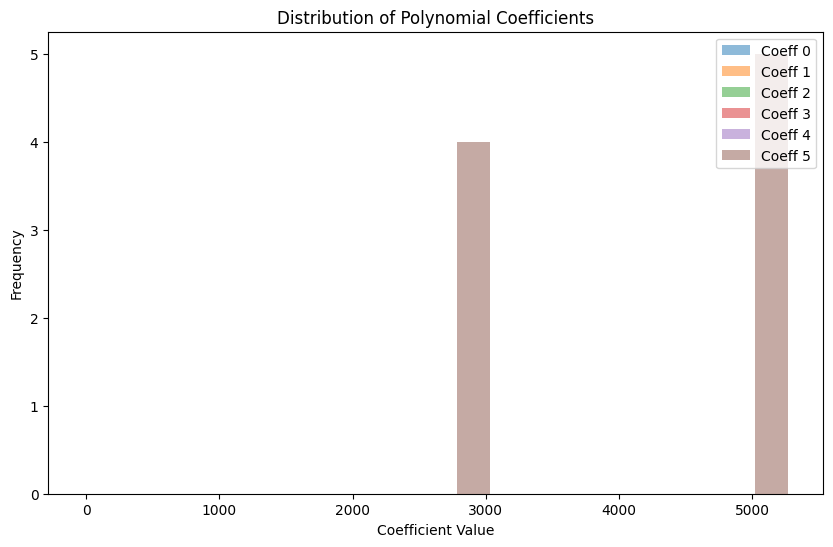

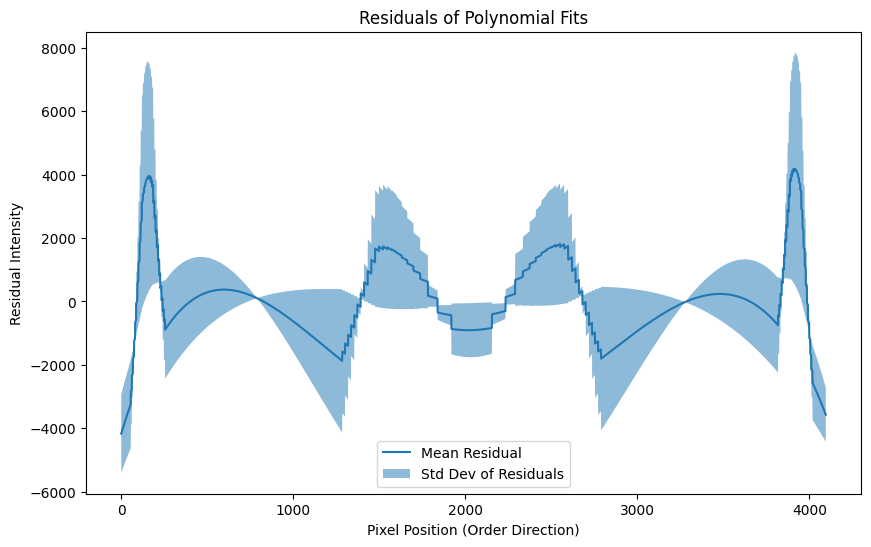

In [4]:
# Analyze the polynomial coefficients
coefficients = [fit['params'] for fit in order_fits]
coefficients = np.array(coefficients)

# Calculate mean and standard deviation of coefficients
mean_coefficients = np.mean(coefficients, axis=0)
std_coefficients = np.std(coefficients, axis=0)

print("Mean coefficients:", mean_coefficients)
print("Standard deviation of coefficients:", std_coefficients)

# Plot the distribution of coefficients
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.hist(coefficients[:, i], bins=10, alpha=0.5, label=f'Coeff {i}')
plt.title('Distribution of Polynomial Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('coefficient_distribution.png', dpi=300)

# Analyze residuals
residuals = []
for fit in order_fits:
    center = fit['center']
    half_width = 5
    order_band = flat_field[center-half_width:center+half_width+1, :]
    order_profile = np.mean(order_band, axis=0)
    x = np.arange(len(order_profile))
    fit_values = polynomial_function(x, *fit['params'])
    residuals.append(order_profile - fit_values)

residuals = np.array(residuals)

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(np.mean(residuals, axis=0), label='Mean Residual')
plt.fill_between(np.arange(len(residuals[0])), 
                 np.mean(residuals, axis=0) - np.std(residuals, axis=0), 
                 np.mean(residuals, axis=0) + np.std(residuals, axis=0), 
                 alpha=0.5, label='Std Dev of Residuals')
plt.title('Residuals of Polynomial Fits')
plt.xlabel('Pixel Position (Order Direction)')
plt.ylabel('Residual Intensity')
plt.legend()
plt.savefig('residuals.png', dpi=300)



By following these steps, you can ensure that you have thoroughly analyzed the flat field data and completed task c comprehensively.